In [2]:
import os 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from tqdm.notebook import tqdm

In [ ]:
BATCH_SIZE = 64
NOISE_LEVEL = 0.95
NUM_EPOCHS = 21
DISPLAY_EVERY = 10

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [4]:
def add_gaussian_noise(image, mean=0, std=0.1):
    noise = np.random.normal(mean, std, image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0., 1.)

class NoisyMNISTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, noise_level=0.1):
        self.dataset = dataset
        self.noise_level = noise_level

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        noisy_image = add_gaussian_noise(image.numpy(), std=self.noise_level)
        return torch.tensor(noisy_image, dtype=torch.float32), image

# Create noisy datasets
noisy_train_dataset = NoisyMNISTDataset(train_dataset, noise_level=NOISE_LEVEL)
noisy_test_dataset = NoisyMNISTDataset(test_dataset, noise_level=NOISE_LEVEL)

# Create data loaders for noisy datasets
noisy_train_loader = torch.utils.data.DataLoader(noisy_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())
noisy_test_loader = torch.utils.data.DataLoader(noisy_test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())

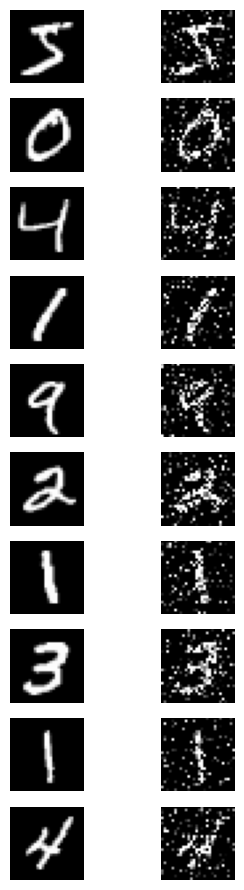

In [5]:
def display_image_grid(dataset, num_rows=10):
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(4, 9))
    for i in range(num_rows):
        noisy_image, original_image = dataset[i]
        axes[i, 0].imshow(original_image.squeeze(), cmap='gray')
        axes[i, 0].axis('off')
        axes[i, 1].imshow(noisy_image.squeeze(), cmap='gray')
        axes[i, 1].axis('off')
    plt.tight_layout()
    plt.show()

display_image_grid(noisy_train_dataset)

In [6]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        
        # Decoder
        self.fc2 = nn.Linear(128, 32 * 7 * 7)
        self.conv3 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv4 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = x.view(-1, 32, 7, 7)
        x = F.relu(self.conv3(x))
        x = torch.tanh(self.conv4(x))
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConvAutoencoder().to(device)

Epoch 1/21:   0%|          | 0/938 [00:00<?, ?batch/s]

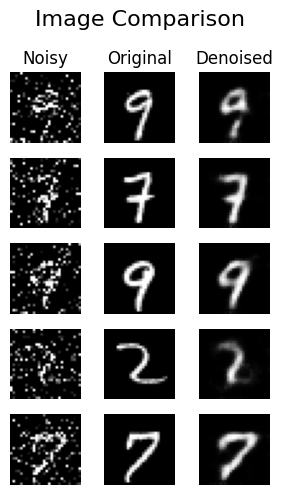

Epoch 2/21:   0%|          | 0/938 [00:00<?, ?batch/s]

Epoch 3/21:   0%|          | 0/938 [00:00<?, ?batch/s]

Epoch 4/21:   0%|          | 0/938 [00:00<?, ?batch/s]

Epoch 5/21:   0%|          | 0/938 [00:00<?, ?batch/s]

Epoch 6/21:   0%|          | 0/938 [00:00<?, ?batch/s]

Epoch 7/21:   0%|          | 0/938 [00:00<?, ?batch/s]

Epoch 8/21:   0%|          | 0/938 [00:00<?, ?batch/s]

Epoch 9/21:   0%|          | 0/938 [00:00<?, ?batch/s]

Epoch 10/21:   0%|          | 0/938 [00:00<?, ?batch/s]

Epoch 11/21:   0%|          | 0/938 [00:00<?, ?batch/s]

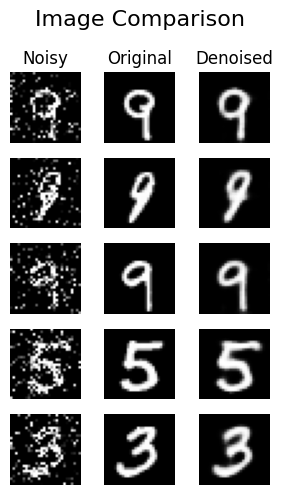

Epoch 12/21:   0%|          | 0/938 [00:00<?, ?batch/s]

Epoch 13/21:   0%|          | 0/938 [00:00<?, ?batch/s]

Epoch 14/21:   0%|          | 0/938 [00:00<?, ?batch/s]

Epoch 15/21:   0%|          | 0/938 [00:00<?, ?batch/s]

Epoch 16/21:   0%|          | 0/938 [00:00<?, ?batch/s]

Epoch 17/21:   0%|          | 0/938 [00:00<?, ?batch/s]

Epoch 18/21:   0%|          | 0/938 [00:00<?, ?batch/s]

Epoch 19/21:   0%|          | 0/938 [00:00<?, ?batch/s]

Epoch 20/21:   0%|          | 0/938 [00:00<?, ?batch/s]

Epoch 21/21:   0%|          | 0/938 [00:00<?, ?batch/s]

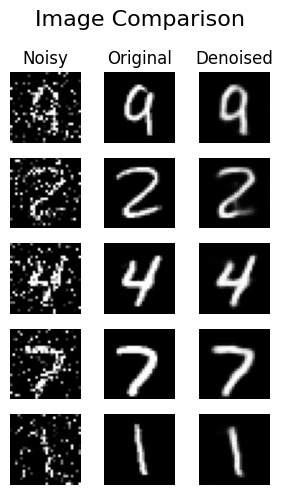

In [7]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train_model(model, dataloader, num_epochs, display_every=5):
    model.to(device)
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        with tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as tepoch:
            for inputs, targets in tepoch:
                inputs, targets = inputs.to(device), targets.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                tepoch.set_postfix(loss=running_loss / (tepoch.n + 1))
                
        if (epoch) % display_every == 0:
            with torch.no_grad():
                val_inputs, val_targets = next(iter(noisy_test_loader))
                val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                val_outputs = model(val_inputs)
                
                fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(3, 5))

                fig.suptitle('Image Comparison', fontsize=16)
                axes[0, 0].set_title("Noisy", fontsize=12)
                axes[0, 1].set_title("Original", fontsize=12)
                axes[0, 2].set_title("Denoised", fontsize=12)
                
                for i in range(5):
                    axes[i, 0].imshow(val_inputs[i].squeeze().cpu().numpy(), cmap='gray')
                    axes[i, 0].axis('off')
                    axes[i, 1].imshow(val_targets[i].squeeze().cpu().numpy(), cmap='gray')
                    axes[i, 1].axis('off')
                    axes[i, 2].imshow(val_outputs[i].squeeze().cpu().numpy(), cmap='gray')
                    axes[i, 2].axis('off')
                
                plt.tight_layout()
                plt.show()

train_model(model, noisy_train_loader, num_epochs=NUM_EPOCHS, display_every=DISPLAY_EVERY)